In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import cv2
import numpy as np
from signal_processor import SignalProcessor

In [ ]:
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"클릭한 좌표: ({x}, {y})")

# 이미지 경로 설정
image_path = '/Users/wjsong/dev_ws/ros-repo-5/admin/src/ai_server/ai_train/dataset/final_map.jpg'
image = cv2.imread(image_path)

cv2.imshow("test", image)
cv2.setMouseCallback("test", mouse_callback)

cv2.waitKey(0)
cv2.destroyAllWindows()

클릭한 좌표: (1156, 941)
클릭한 좌표: (1512, 904)


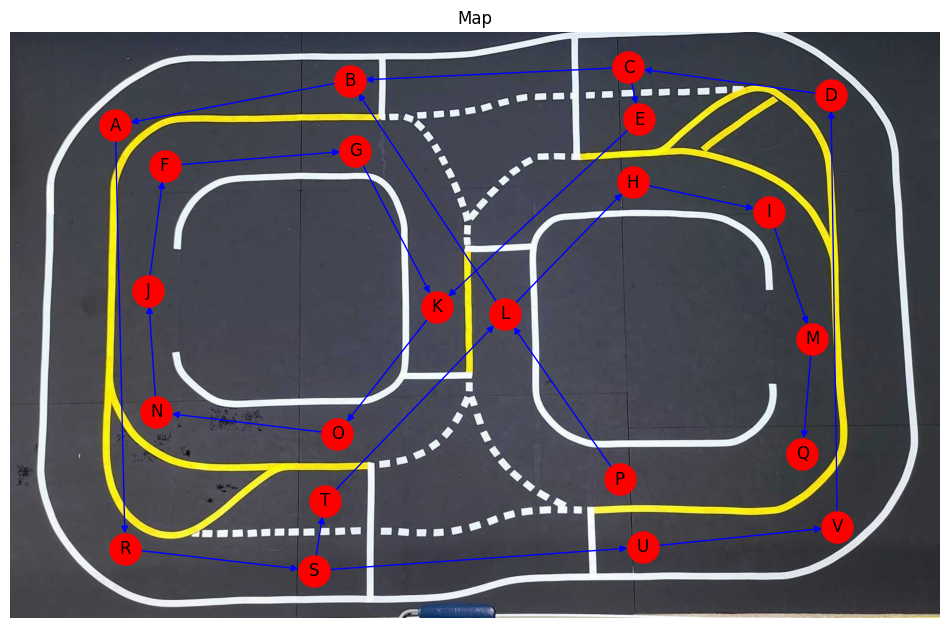

In [3]:
# 1. 원본 맵 이미지 불러오기
img_path = "/home/pepsi/Downloads/final_map.jpg" 
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. 그래프 정의
G = nx.DiGraph()
G.add_edges_from([
    ('A', 'R'), ('B', 'A'), ('C', 'B'), ('C', 'E'), ('E', 'K'), ('D', 'C'),
    ('F', 'G'), ('G', 'K'), ('H', 'I'), ('I', 'M'),
    ('J', 'F'), ('K', 'O'), ('L', 'B'), ('L', 'H'), ('M', 'Q'),
    ('N', 'J'), ('O', 'N'), ('P', 'L'), ('P', 'L'),
    ('R', 'S'), ('S', 'T'), ('S', 'U'), ('T', 'L'), ('U', 'V'), ('V', 'D')
])

# 3. 노드 위치 설정 (두 번째 이미지 기준 좌표)
positions = {
    "A": (192, 170), "B": (621, 88), "C": (1130, 64), "D": (1500, 115), "E": (1150, 159),
    "F": (282, 244), "G": (631, 216), "H": (1138, 274), "I": (1387, 328),
    "J": (252, 472), "K": (780, 502), "L": (904, 515), "M": (1466, 560),
    "N": (267, 694), "O": (598, 734), "P": (1114, 817), "Q": (1448, 770),
    "R": (210, 944), "S": (555, 984), "T": (575, 857), "U": (1156, 941), "V": (1512, 904)
}

# 4. 이미지와 그래프 함께 표시
plt.figure(figsize=(12, 8))
plt.imshow(img)
nx.draw(G, pos=positions, with_labels=True, node_color='red', edge_color='blue', node_size=500, font_color='black')
plt.axis('off')
plt.title("Map")
plt.show()

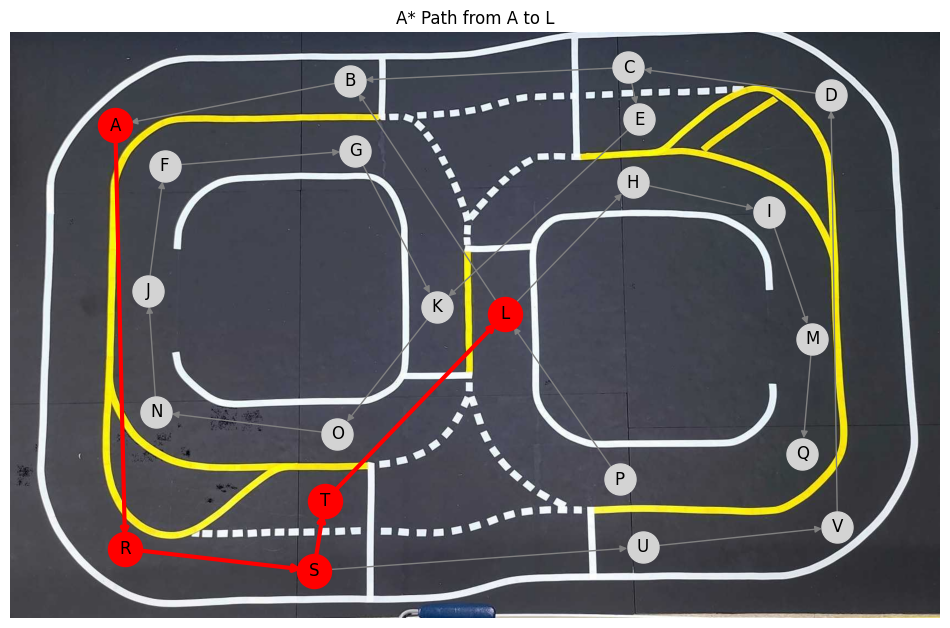

In [4]:
# 4. 휴리스틱 함수 (유클리디안 거리)
def heuristic(n1, n2):
    x1, y1 = positions[n1]
    x2, y2 = positions[n2]
    return np.hypot(x2 - x1, y2 - y1)

# 5. 가중치 추가 (거리 기반)
for u, v in G.edges:
    dist = heuristic(u, v)
    G[u][v]['weight'] = dist

# 6. 출발지와 목적지 설정
start_node = "A"
end_node = "L"

# 7. A* 알고리즘으로 최단 경로 찾기
path = nx.astar_path(G, start_node, end_node, heuristic=heuristic)

# 8. 경로 시각화
plt.figure(figsize=(12, 8))
plt.imshow(img)

# 전체 그래프 표시
nx.draw(G, pos=positions, with_labels=True, node_color='lightgray', edge_color='gray', node_size=500, font_color='black')

# 최단 경로 강조
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_nodes(G, pos=positions, nodelist=path, node_color='red', node_size=600)
nx.draw_networkx_edges(G, pos=positions, edgelist=path_edges, edge_color='red', width=3)

plt.axis('off')
plt.title(f"A* Path from {start_node} to {end_node}")
plt.show()

In [86]:
marker_positions = {
    "A": (0.213, 0.112), "B": (0.225, 0.178), "C": (0.209, 0.223), "D": (0.17, 0.225), "E": (0.166, 0.182),
    "F": (0.172, 0.094), "G": (0.179, 0.137), "H": (0.134, 0.149), "I": (0.104, 0.156),
    "J": (0.095, 0.025), "K": (0.77, 0.065), "L": (0.068, 0.071), "M": (0.027, 0.094),
    "N": (0.043, -0.021), "O": (0.01, -0.011), "P": (-0.031, 0.005), "Q": (-0.032, 0.036),
    "R": (-0.026, -0.089), "S": (-0.063, -0.075), "T": (-0.027, -0.045), "U": (-0.068, -0.022), "V": (-0.069, 0.015)
}

In [95]:
import time

sp = SignalProcessor(window_size=5, alpha=0.3)
behavior = {"forward": 0, "left": 1, "right": 2, 'stop': 3}

goal_node = 'L'  # 목표 노드
scale = 1000  # 1m = 1000px로 위치 변환

def get_direction(current_pos, next_pos, goal_pos):
    """
    현재 → 다음 방향벡터와 현재 → 목표 방향벡터의 각도를 통해 방향을 결정함
    """
    vec_current_to_next = np.array(next_pos) - np.array(current_pos)
    vec_current_to_goal = np.array(goal_pos) - np.array(current_pos)

    angle = np.arctan2(
        vec_current_to_goal[1], vec_current_to_goal[0]
    ) - np.arctan2(
        vec_current_to_next[1], vec_current_to_next[0]
    )
    angle = np.degrees(angle)
    angle = (angle + 360) % 360  # 각도 정규화

    if angle < 45 or angle > 315:
        return "forward"
    elif 45 <= angle <= 135:
        return "left"
    elif 225 <= angle <= 315:
        return "right"
    else:
        return "stop"
    

def find_nearest_node(robot_pos, positions):
    min_dist = float('inf')
    nearest_node = None
    for node, pos in marker_positions.items():
        dist = np.linalg.norm(np.array(pos) - np.array(robot_pos))
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

# === 아루코 pose 추정 함수 ===
def pose_estimation(frame, aruco_dict_type, matrix_coefficients, distortion_coefficients, marker_length):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)
    detector = cv2.aruco.ArucoDetector(aruco_dict, cv2.aruco.DetectorParameters())
    corners, ids, _ = detector.detectMarkers(gray)

    if ids is not None and len(corners) > 0:
        for i in range(len(ids)):
            rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(
                corners[i], marker_length, matrix_coefficients, distortion_coefficients
            )

            # 위치 및 방향 계산
            pos = tvec[0][0]
            x, y, z = pos
            
            robot_pos = (round(sp.moving_average(x), 3), round(sp.moving_average(y), 3))
            
            node = find_nearest_node(robot_pos, marker_positions)

            if node == goal_node:
                print("arrived")
                return frame

            if nx.has_path(G, start_node[0], goal_node):
                path = nx.shortest_path(G, node[0], goal_node)
                if len(path) >= 2:
                    current_node = path[0]
                    next_node = path[1]
                    next_pos = marker_positions[next_node]
                    current_pos = marker_positions[current_node]
                    
                    direction = get_direction(current_pos, next_pos, marker_positions[goal_node])
                    print(f"행동: {behavior[direction]}")

            cv2.aruco.drawDetectedMarkers(frame, corners)
            cv2.drawFrameAxes(frame, matrix_coefficients, distortion_coefficients, rvec, tvec, marker_length * 0.5)

    return frame

# === 실시간 실행 ===
ARUCO_DICT = {
    "DICT_4X4_100": cv2.aruco.DICT_4X4_100
}

aruco_dict_type = ARUCO_DICT["DICT_4X4_100"]
k = np.load("/home/pepsi/dev_ws/ros-repo-5/admin/src/ai_server/ai_train/calib_images/camera_matrix.npy")
d = np.load("/home/pepsi/dev_ws/ros-repo-5/admin/src/ai_server/ai_train/calib_images/distortion_coeffs.npy")
marker_length = 0.03  # 3cm

video = cv2.VideoCapture(2)
time.sleep(2.0)

while True:
    ret, frame = video.read()
    if not ret:
        break

    output = pose_estimation(frame, aruco_dict_type, k, d, marker_length)
    cv2.imshow("Estimated Pose", output)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
arrived
